In [ ]:
from google.colab import drive
drive.mount('/content/drive')

!mkdir -p ~/.kaggle
!cp /content/drive/MyDrive/Colab\ Notebooks/kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!pip install -q kaggle



!kaggle datasets download -d vbookshelf/v2-plant-seedlings-dataset

!unzip v2-plant-seedlings-dataset.zip

Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
  inflating: nonsegmentedv2/Charlock/309.png  
  inflating: nonsegmentedv2/Charlock/31.png  
  inflating: nonsegmentedv2/Charlock/310.png  
  inflating: nonsegmentedv2/Charlock/311.png  
  inflating: nonsegmentedv2/Charlock/312.png  
  inflating: nonsegmentedv2/Charlock/313.png  
  inflating: nonsegmentedv2/Charlock/314.png  
  inflating: nonsegmentedv2/Charlock/315.png  
  inflating: nonsegmentedv2/Charlock/316.png  
  inflating: nonsegmentedv2/Charlock/317.png  
  inflating: nonsegmentedv2/Charlock/318.png  
  inflating: nonsegmentedv2/Charlock/319.png  
  inflating: nonsegmentedv2/Charlock/32.png  
  inflating: nonsegmentedv2/Charlock/320.png  
  inflating: nonsegmentedv2/Charlock/321.png  
  inflating: nonsegmentedv2/Charlock/322.png  
  inflating: nonsegmentedv2/Charlock/323.png  
  inflating: nonsegmentedv2/Charlock/324.png  
  inflating: nonsegmentedv2/Charlock/325.png  
  inflating: nonsegmentedv2/Cha

# **Compréhension des données**


In [ ]:
import os
import matplotlib.pyplot as plt
import cv2
from collections import Counter
import os
import pandas as pd
import numpy as np
from PIL import Image  # For handling image shapes if needed
import matplotlib.pyplot as plt
import seaborn as sns
from typing import List, Tuple

dataset_path = 'nonsegmentedv2'

In [ ]:
# Create the DataFrame
def create_dataframe(dataset_path: str) -> pd.DataFrame:
    image_paths = []
    image_shapes = []
    classes = []

    # Walk through the dataset directory
    for class_name in os.listdir(dataset_path):
        class_dir = os.path.join(dataset_path, class_name)
        if os.path.isdir(class_dir):
            for img_file in os.listdir(class_dir):
                img_path = os.path.join(class_dir, img_file)
                try:
                    with Image.open(img_path) as img:
                        image_paths.append(img_path)
                        image_shapes.append(img.size)  # (width, height)
                        classes.append(class_name)
                except:
                    print(f"Skipping corrupt/invalid image: {img_path}")

    # Calculate class weights for balancing
    class_counts = pd.Series(classes).value_counts()
    class_weights = 1. / class_counts
    image_weights = [class_weights[cls] for cls in classes]

    # Create DataFrame
    data = {
        'image_path': image_paths,
        'width': [shape[0] for shape in image_shapes],
        'height': [shape[1] for shape in image_shapes],
        'class': classes,
        'weight': image_weights
    }

    return pd.DataFrame(data)

# Create the DataFrame
data_df = create_dataframe(dataset_path)

# Display DataFrame and its statistics
display(data_df.head())
display(data_df.info())
display(data_df.describe())

image_path  width  height       class   weight
0    nonsegmentedv2/Sugar beet/2.png    308     308  Sugar beet  0.00216
1  nonsegmentedv2/Sugar beet/100.png   1217    1217  Sugar beet  0.00216
2   nonsegmentedv2/Sugar beet/50.png    546     546  Sugar beet  0.00216
3  nonsegmentedv2/Sugar beet/422.png    564     564  Sugar beet  0.00216
4  nonsegmentedv2/Sugar beet/306.png    602     602  Sugar beet  0.00216

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5539 entries, 0 to 5538
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   image_path  5539 non-null   object 
 1   width       5539 non-null   int64  
 2   height      5539 non-null   int64  
 3   class       5539 non-null   object 
 4   weight      5539 non-null   float64
dtypes: float64(1), int64(2), object(2)
memory usage: 216.5+ KB


None

width       height       weight
count  5539.000000  5539.000000  5539.000000
mean    355.202022   354.783535     0.002166
std     295.108600   292.700461     0.000855
min      49.000000    49.000000     0.001312
25%     152.000000   152.000000     0.001403
50%     267.000000   267.000000     0.001859
75%     469.000000   469.000000     0.002985
max    3652.000000  3457.000000     0.003953

Les images varient énormément en taille.

La plus petite image mesure 49 × 49 pixels.

La plus grande atteint 3 457 × 3 652 pixels.

Moyenne : environ 355 × 355 pixels.

Médiane : 267 × 267 pixels.

In [ ]:
# Get all class folders
classes = os.listdir(dataset_path)
print(f"Nombre de classes d'espèces végétales: {len(classes)}")
print(f"Classes: {sorted(classes)}")

Nombre de classes d'espèces végétales: 12
Classes: ['Black-grass', 'Charlock', 'Cleavers', 'Common Chickweed', 'Common wheat', 'Fat Hen', 'Loose Silky-bent', 'Maize', 'Scentless Mayweed', 'ShepherdтАЩs Purse', 'Small-flowered Cranesbill', 'Sugar beet']


In [ ]:
# Count images per class
class_counts = {}
for class_name in classes:
    class_path = os.path.join(dataset_path, class_name)
    image_count = len(os.listdir(class_path))
    class_counts[class_name] = image_count

# Display class distribution sorted by count (largest to smallest)
for class_name, count in sorted(class_counts.items(), key=lambda x: x[1], reverse=True):
    print(f"{class_name}: {count} images")

Loose Silky-bent: 762 images
Common Chickweed: 713 images
Scentless Mayweed: 607 images
Small-flowered Cranesbill: 576 images
Fat Hen: 538 images
Sugar beet: 463 images
Charlock: 452 images
Cleavers: 335 images
Black-grass: 309 images
ShepherdтАЩs Purse: 274 images
Maize: 257 images
Common wheat: 253 images


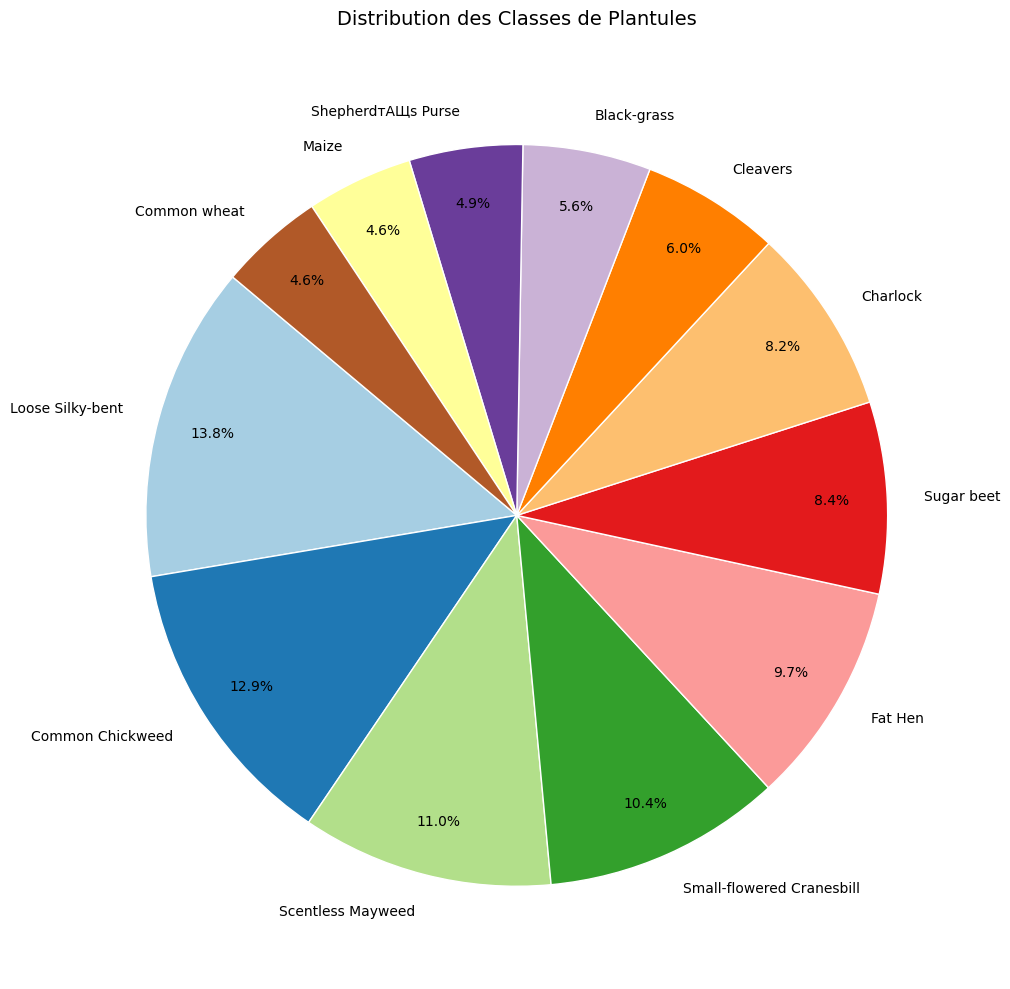

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Sort the classes by count (largest to smallest)
sorted_items = sorted(class_counts.items(), key=lambda x: x[1], reverse=True)
labels = [item[0] for item in sorted_items]
counts = [item[1] for item in sorted_items]

# Calculate percentages
percentages = np.array(counts) / np.sum(counts) * 100

# Plot the pie chart
plt.figure(figsize=(12, 10))
plt.pie(percentages,
        labels=labels,
        autopct='%1.1f%%',
        startangle=140,
        colors=plt.cm.Paired.colors,
        textprops={'fontsize': 10},          # Font size for labels
        wedgeprops={'edgecolor': 'white'},  # Add white edge for better separation
        pctdistance=0.85)                   # Position percentage labels

# Increase the size of percentage numbers
plt.setp(plt.findobj(plt.gca(), lambda x: isinstance(x, plt.Text) and x.get_text().endswith('%')), fontsize=10)

plt.title('Distribution des Classes de Plantules', pad=20, fontsize=14)
plt.tight_layout()
plt.show()

Le dataset souffre d'un déséquilibre inter-classes à considérer dans la préparation des données.

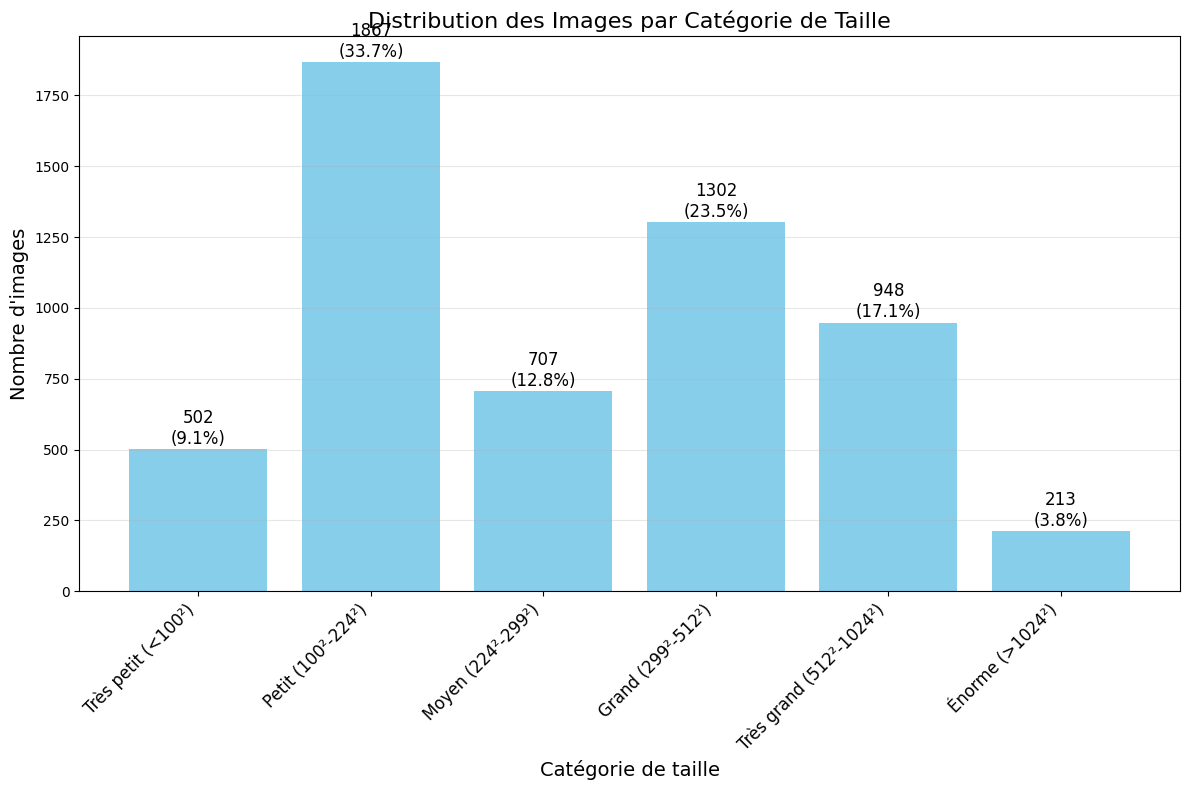

Résolution médiane dans le dataset: 267×267 pixels
Résolution moyenne dans le dataset: 355×355 pixels


In [ ]:
# Calculate total pixels (area)
data_df['total_pixels'] = data_df['width'] * data_df['height']

# Create bins for image sizes
size_bins = [0, 100*100, 224*224, 299*299, 512*512, 1024*1024, float('inf')]
size_labels = ['Très petit (<100²)', 'Petit (100²-224²)', 'Moyen (224²-299²)',
               'Grand (299²-512²)', 'Très grand (512²-1024²)', 'Énorme (>1024²)']

data_df['size_category'] = pd.cut(data_df['total_pixels'], bins=size_bins, labels=size_labels)
size_counts = data_df['size_category'].value_counts().sort_index()

# Create a single figure with better proportions for one chart
plt.figure(figsize=(12, 8))
bars = plt.bar(size_counts.index, size_counts.values, color='skyblue')
plt.xlabel('Catégorie de taille', fontsize=14)
plt.ylabel('Nombre d\'images', fontsize=14)
plt.title('Distribution des Images par Catégorie de Taille', fontsize=16)
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.grid(axis='y', alpha=0.3)

# Add count labels on bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 5,
            f'{height}\n({height/len(data_df)*100:.1f}%)',
            ha='center', va='bottom', fontsize=12)

plt.tight_layout()
plt.show()

# Calculate the median image dimensions as a potential target resolution
median_width = data_df['width'].median()
median_height = data_df['height'].median()
print(f"Résolution médiane dans le dataset: {median_width:.0f}×{median_height:.0f} pixels")
print(f"Résolution moyenne dans le dataset: {data_df['width'].mean():.0f}×{data_df['height'].mean():.0f} pixels")

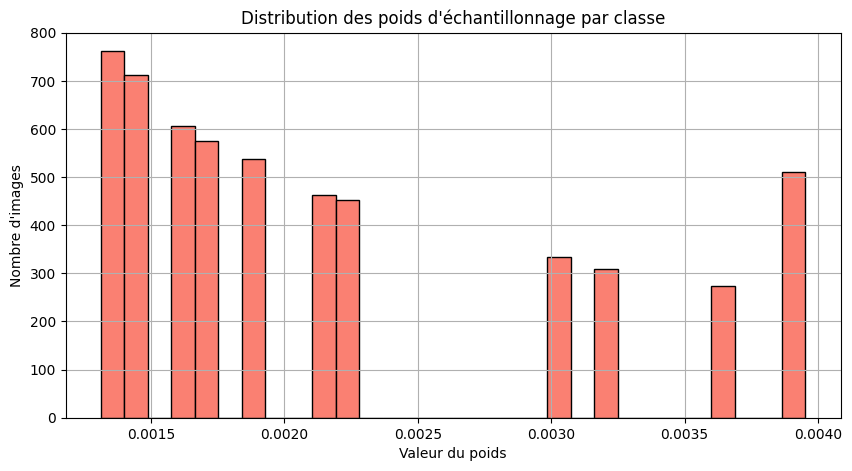

In [ ]:
plt.figure(figsize=(10, 5))
plt.hist(data_df['weight'], bins=30, color='salmon', edgecolor='black')
plt.title('Distribution des poids d\'échantillonnage par classe')
plt.xlabel('Valeur du poids')
plt.ylabel('Nombre d\'images')
plt.grid(True)
plt.show()

La distribution du poids des images (et donc de leur qualité) présente de fortes disparités.

In [ ]:
# Calculate resolution as the product of height and width
data_df['resolution'] = data_df['width'] * data_df['height']

# Calculate ratio as the division of height by width
data_df['ratio'] = data_df['height'] / data_df['width']

# Count square images (ratio = 1.0 ± small tolerance for floating point)
square_images = len(data_df[np.isclose(data_df['ratio'], 1.0, atol=0.01)])

# Calculate the proportion of square images
total_images = len(data_df)
square_image_proportion = (square_images / total_images) * 100

# Output the proportion of square images
print(f"Proportion d'images carrées : {square_image_proportion:.2f}%")

# Show some statistics
print("\nStatistiques de résolution des images :")
print(f"Résolution minimale : {data_df['resolution'].min()} pixels")
print(f"Résolution maximale : {data_df['resolution'].max()} pixels")
print(f"Résolution moyenne : {data_df['resolution'].mean():.0f} pixels")

Proportion d'images carrées : 99.17%

Statistiques de résolution des images :
Résolution minimale : 2401 pixels
Résolution maximale : 12624964 pixels
Résolution moyenne : 212316 pixels


Analyse des modes de couleur des images...


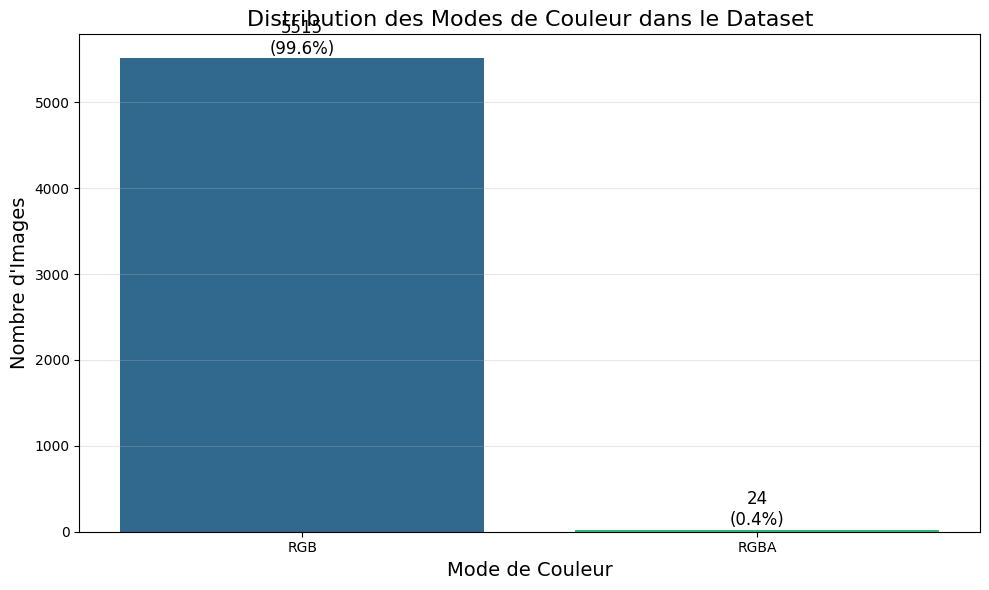

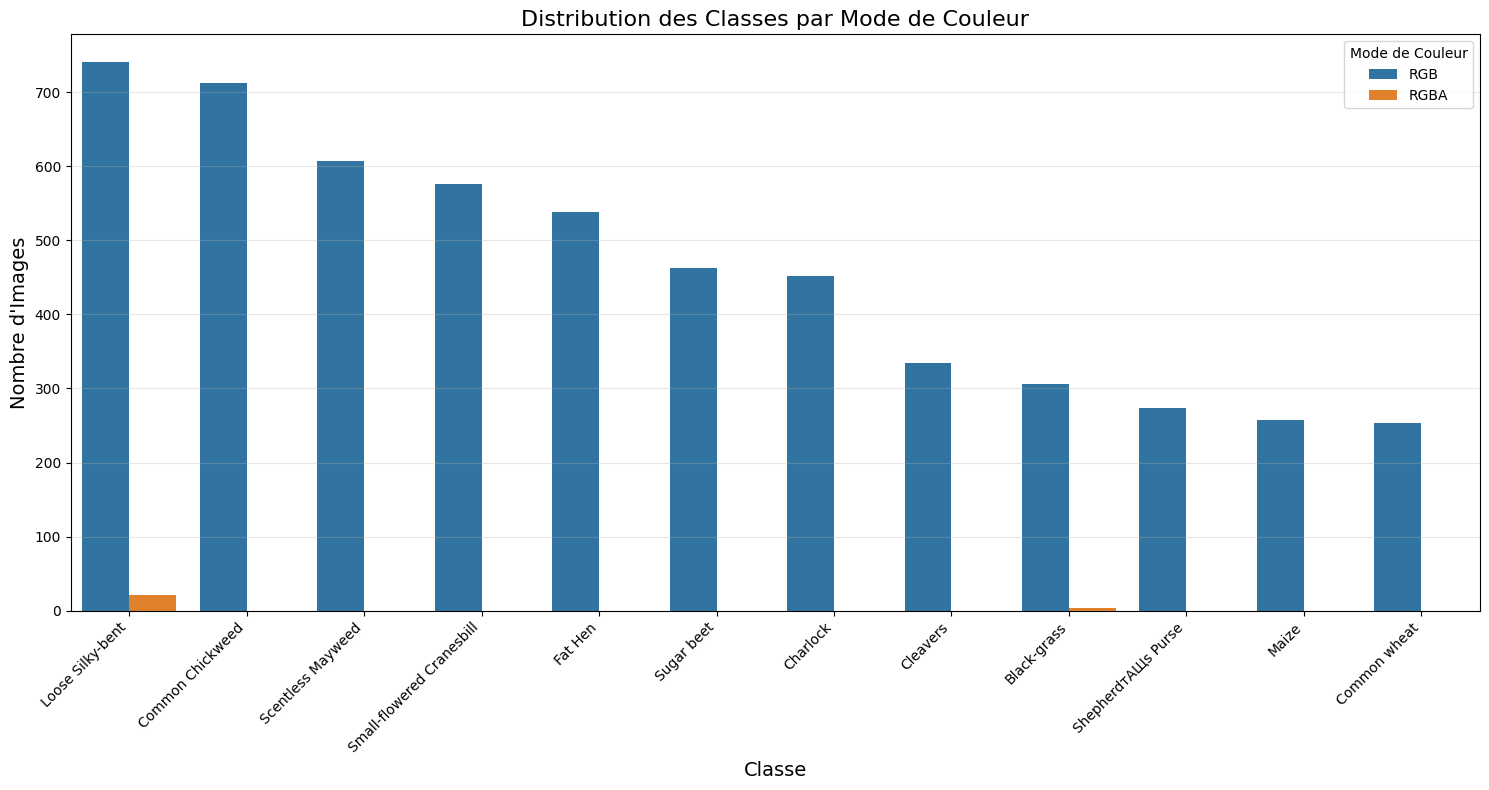


Pourcentage de chaque mode de couleur par classe (%)


color_mode                    RGB  RGBA
class                                  
Black-grass                 99.03  0.97
Charlock                   100.00  0.00
Cleavers                   100.00  0.00
Common Chickweed           100.00  0.00
Common wheat               100.00  0.00
Fat Hen                    100.00  0.00
Loose Silky-bent            97.24  2.76
Maize                      100.00  0.00
Scentless Mayweed          100.00  0.00
ShepherdтАЩs Purse         100.00  0.00
Small-flowered Cranesbill  100.00  0.00
Sugar beet                 100.00  0.00
All                         99.57  0.43

In [ ]:
# Analyse des modes de couleur (RGB/RGBA) dans le dataset
from PIL import Image
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Fonction pour déterminer le mode de couleur d'une image
def get_color_mode(img_path):
    try:
        with Image.open(img_path) as img:
            return img.mode
    except Exception as e:
        print(f"Erreur lors de l'ouverture de {img_path}: {e}")
        return "Erreur"

# Appliquer la fonction à toutes les images et ajouter au DataFrame
print("Analyse des modes de couleur des images...")
data_df['color_mode'] = data_df['image_path'].apply(get_color_mode)

# 1. Distribution globale des modes de couleur
plt.figure(figsize=(10, 6))
color_mode_counts = data_df['color_mode'].value_counts()
bars = plt.bar(color_mode_counts.index, color_mode_counts.values, color=sns.color_palette("viridis", len(color_mode_counts)))
plt.title('Distribution des Modes de Couleur dans le Dataset', fontsize=16)
plt.xlabel('Mode de Couleur', fontsize=14)
plt.ylabel('Nombre d\'Images', fontsize=14)
plt.grid(axis='y', alpha=0.3)

# Ajouter les labels de valeur et pourcentage sur les barres
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 5,
             f'{height}\n({height/len(data_df)*100:.1f}%)',
             ha='center', va='bottom', fontsize=12)

plt.tight_layout()
plt.show()

# 2. Distribution des classes au sein de chaque mode de couleur
plt.figure(figsize=(15, 8))
ax = sns.countplot(x='class', hue='color_mode', data=data_df,
                   order=data_df['class'].value_counts().index)
plt.title('Distribution des Classes par Mode de Couleur', fontsize=16)
plt.xlabel('Classe', fontsize=14)
plt.ylabel('Nombre d\'Images', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.legend(title='Mode de Couleur')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

# 3. Pourcentage de chaque mode de couleur par classe
# Créer un tableau croisé dynamique
color_class_pivot = pd.crosstab(data_df['class'], data_df['color_mode'],
                               normalize='index', margins=True) * 100

# Afficher le résultat
print("\nPourcentage de chaque mode de couleur par classe (%)")
display(color_class_pivot.round(2))

Presque toutes les images utilisent le codage RGB, avec une minorité (0,4 %) en RGBA.

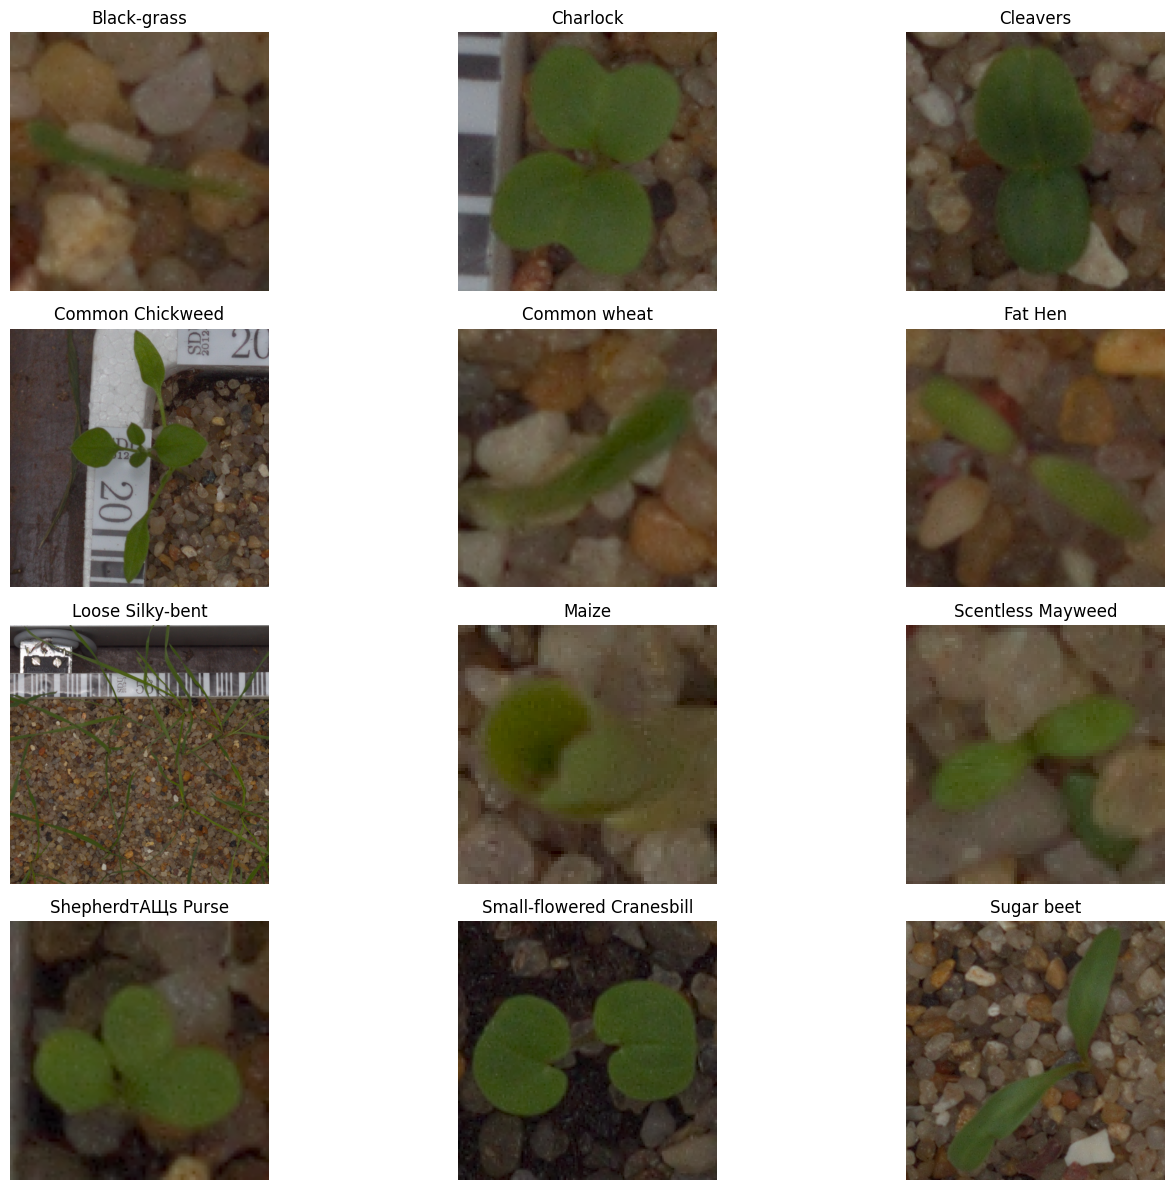

In [ ]:
# Display sample images from each class
plt.figure(figsize=(15, 12))
i = 1

for class_name in sorted(classes):
    class_path = os.path.join(dataset_path, class_name)
    images = os.listdir(class_path)

    # Get a sample image
    if images:
        img_path = os.path.join(class_path, images[0])
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB

        plt.subplot(4, 3, i)
        plt.imshow(img)
        plt.title(class_name)
        plt.axis('off')
        i += 1

plt.tight_layout()
plt.show()

Les arrière-plans sont hétérogènes (gravillon, bâches, objets divers...).

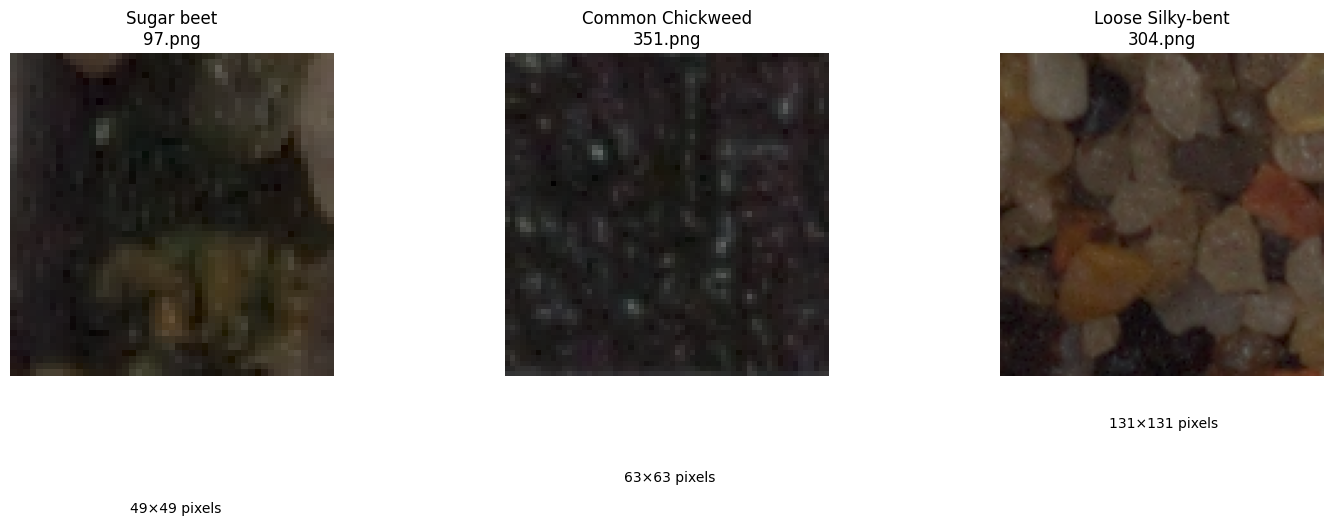

In [ ]:
def plot_specific_images(data_df, image_list):
    """
    Affiche des images spécifiques du dataset.

    Args:
        data_df: DataFrame contenant les informations sur les images
        image_list: Liste de tuples (nom_fichier, nom_classe)
    """
    n_images = len(image_list)
    fig, axes = plt.subplots(1, n_images, figsize=(n_images*5, 5))

    # Si une seule image, axes n'est pas un tableau
    if n_images == 1:
        axes = [axes]

    for i, (filename, class_name) in enumerate(image_list):
        # Trouver l'image correspondante dans le DataFrame
        # Extraire le nom de fichier de chaque chemin d'image
        data_df['filename'] = data_df['image_path'].apply(lambda x: os.path.basename(x))

        # Filtrer les images correspondant au nom de fichier et à la classe
        matching_rows = data_df[(data_df['filename'] == filename) &
                                (data_df['class'] == class_name)]

        if len(matching_rows) == 0:
            axes[i].text(0.5, 0.5, f"Image non trouvée:\n{filename}\n{class_name}",
                         ha='center', va='center', color='red')
            axes[i].set_title(f"Non trouvée")
            axes[i].axis('off')
        else:
            # Charger et afficher l'image
            img_path = matching_rows.iloc[0]['image_path']
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

            axes[i].imshow(img)
            axes[i].set_title(f"{class_name}\n{filename}")
            axes[i].axis('off')

            # Afficher la dimension de l'image
            height, width = img.shape[:2]
            axes[i].text(width/2, height+20, f"{width}×{height} pixels",
                         ha='center', fontsize=10)

    plt.tight_layout()
    plt.show()

    # Supprimer la colonne filename temporaire si elle existe
    if 'filename' in data_df.columns:
        data_df.drop('filename', axis=1, inplace=True)

# Test de la fonction
plot_specific_images(data_df, [('97.png', 'Sugar beet'),
                              ('351.png', 'Common Chickweed'),
                              ('304.png', 'Loose Silky-bent')])

Trois images ne contiennent aucune plante.

In [ ]:
# 1. Vérifions d'abord les noms de colonnes réels
print("Colonnes disponibles dans data_df:", data_df.columns.tolist())

# 2. Adaptons les noms de colonnes dans le code
# Supposons que les colonnes s'appellent 'class' et 'image_path' comme dans votre fonction

# Créons une colonne 'Filename' si elle n'existe pas
if 'Filename' not in data_df.columns:
    data_df['Filename'] = data_df['image_path'].apply(os.path.basename)

# 3. Version corrigée de l'affichage des données
try:
    # Utilisation de noms de colonnes cohérents
    charlock_samples = data_df[
        (data_df['class'] == 'Charlock') &
        (data_df['Filename'].isin(['328.png', '419.png', '18.png']))
    ]
    display(charlock_samples)
except KeyError as e:
    print(f"Erreur de colonne: {str(e)}")
    print("Colonnes disponibles:", data_df.columns.tolist())

# 4. Version optimisée de plot_specific_images
def plot_specific_images(data_df, image_specs, figsize=(15, 5)):
    """
    Affiche des images spécifiques avec gestion d'erreur améliorée

    Args:
        data_df: DataFrame contenant les images
        image_specs: Liste de tuples (nom_fichier, classe_attendue)
        figsize: Taille de la figure
    """
    # Vérification des colonnes requises
    required_cols = ['image_path', 'class']
    missing_cols = [col for col in required_cols if col not in data_df.columns]
    if missing_cols:
        raise ValueError(f"Colonnes manquantes: {missing_cols}")

    plt.figure(figsize=figsize)

    for i, (img_name, expected_class) in enumerate(image_specs, 1):
        # Recherche avec gestion des erreurs
        try:
            img_rows = data_df[
                data_df['image_path'].str.endswith(img_name) &
                (data_df['class'] == expected_class)
            ]

            if img_rows.empty:
                print(f"⚠ Image {img_name} ({expected_class}) introuvable")
                continue

            img_path = img_rows.iloc[0]['image_path']

            plt.subplot(1, len(image_specs), i)
            with Image.open(img_path) as img:
                plt.imshow(img)
                plt.title(f"{img_name}\n{expected_class}", fontsize=9, pad=5)
            plt.axis('off')

        except Exception as e:
            print(f"Erreur avec {img_name}: {str(e)}")
            continue

    plt.tight_layout()
    plt.show()

# 5. Exemple d'utilisation
plot_specific_images(data_df, [
    ('18.png', 'Charlock'),
    ('328.png', 'Charlock'),
    ('419.png', 'Charlock')
])

Colonnes disponibles dans data_df: ['image_path', 'width', 'height', 'class', 'weight', 'total_pixels', 'size_category', 'resolution', 'ratio', 'color_mode']


image_path  width  height     class    weight  \
2514  nonsegmentedv2/Charlock/328.png    514     514  Charlock  0.002212   
2648   nonsegmentedv2/Charlock/18.png    159     159  Charlock  0.002212   
2667  nonsegmentedv2/Charlock/419.png    358     358  Charlock  0.002212   

      total_pixels            size_category  resolution  ratio color_mode  \
2514        264196  Très grand (512²-1024²)      264196    1.0        RGB   
2648         25281        Petit (100²-224²)       25281    1.0        RGB   
2667        128164        Grand (299²-512²)      128164    1.0        RGB   

     Filename  
2514  328.png  
2648   18.png  
2667  419.png

La classe Charlok illustre trois stades de croissance (18.png = début, 419.png = intermédiaire, 328.png = avancé). L'ordre des numéros de fichier ne reflète pas la chronologie réelle. On observe cependant une corrélation positive entre la taille de l'image, la netteté et le stade de développement, probablement due à un recadrage différencié

***Interprétations***

* Les images varient énormément en taille.

* La plus petite image mesure 49 × 49 pixels.

* La plus grande atteint 3 457 × 3 652 pixels.

* Moyenne : environ 355 × 355 pixels.

* Médiane : 267 × 267 pixels.

* Le dataset souffre d'un déséquilibre inter-classes à considérer dans l'entraînement.

* La distribution du poids des images (et donc de leur qualité) présente de fortes disparités.

* 99,17% des images de jeu de données sont carrées, c'est-à-dire qu'elles ont un rapport largeur/hauteur (aspect ratio) égal à 1.

* Presque toutes les images utilisent le codage RGB, avec une minorité (0,4 %) en RGBA.

* Les arrière-plans sont hétérogènes (gravillon, bâches, objets divers...).

* Il y a trois images ne contiennent aucune plante.

* La classe Charlok illustre trois stades de croissance (18.png = début, 419.png = intermédiaire, 328.png = avancé). L'ordre des numéros de fichier ne reflète pas la chronologie réelle. On observe cependant une corrélation positive entre la taille de l'image, la netteté et le stade de développement, probablement due à un recadrage différencié.

***Décisions***
1. Suppression des 3 images qui ne contiennent pas des plantes.

2. Convertir des images RGBA en RGB (ou bien les supprimer).

3. Equilibrage de nombres d'images dans chaque classe (250).

4. Résolution fixe pour toutes les images. 224x224

5. Segmentation des images.

# **Préparation des données**

In [ ]:
# 1. Suppression des 3 images qui ne contiennent pas des plantes
def remove_problematic_images(data_df):
    """Supprime les images identifiées comme problématiques du DataFrame."""
    problematic_images = [('97.png', 'Sugar beet'),
                        ('351.png', 'Common Chickweed'),
                        ('304.png', 'Loose Silky-bent')]

    # Créer une colonne temporaire avec le nom du fichier
    data_df['filename'] = data_df['image_path'].apply(lambda x: os.path.basename(x))

    # Création d'un masque pour identifier les lignes à supprimer
    rows_to_remove = []
    for filename, class_name in problematic_images:
        matching_rows = data_df[(data_df['filename'] == filename) &
                               (data_df['class'] == class_name)].index
        rows_to_remove.extend(matching_rows)

    print(f"Suppression de {len(rows_to_remove)} images problématiques...")
    data_clean_df = data_df.drop(rows_to_remove).reset_index(drop=True)

    # Suppression de la colonne temporaire
    data_clean_df.drop('filename', axis=1, inplace=True)

    return data_clean_df

# Nettoyer le DataFrame
data_clean_df = remove_problematic_images(data_df)
print(f"Dataset nettoyé: {len(data_clean_df)} images")

Suppression de 3 images problématiques...
Dataset nettoyé: 5536 images


In [ ]:
# 2. Suppression des images RGBA (au lieu de les convertir en RGB)
def is_rgb_image(img_path):
    """Vérifie si une image est au format RGB (et non RGBA). Retourne True si c'est une image RGB."""
    img = cv2.imread(img_path, cv2.IMREAD_UNCHANGED)

    # Vérifier si l'image a 4 canaux (RGBA)
    if img is not None and len(img.shape) == 3 and img.shape[2] == 4:
        print(f"Image RGBA détectée (sera supprimée): {img_path}")
        return False

    return True  # Image RGB ou autre format non-RGBA

# Filtrer les images RGBA
rgb_mask = [is_rgb_image(img_path) for img_path in data_clean_df['image_path']]
data_rgb_df = data_clean_df[rgb_mask].reset_index(drop=True)

# Afficher le résultat
n_removed = len(data_clean_df) - len(data_rgb_df)
print(f"Nombre d'images RGBA supprimées: {n_removed}")
print(f"Nombre d'images RGB conservées: {len(data_rgb_df)}")

# Mise à jour du DataFrame
data_clean_df = data_rgb_df

Image RGBA détectée (sera supprimée): nonsegmentedv2/Loose Silky-bent/604-13.png
Image RGBA détectée (sera supprimée): nonsegmentedv2/Loose Silky-bent/604-7.png
Image RGBA détectée (sera supprimée): nonsegmentedv2/Loose Silky-bent/604-6.png
Image RGBA détectée (sera supprimée): nonsegmentedv2/Loose Silky-bent/604-9.png
Image RGBA détectée (sera supprimée): nonsegmentedv2/Loose Silky-bent/311-3.png
Image RGBA détectée (sera supprimée): nonsegmentedv2/Loose Silky-bent/604-5.png
Image RGBA détectée (sera supprimée): nonsegmentedv2/Loose Silky-bent/311-2.png
Image RGBA détectée (sera supprimée): nonsegmentedv2/Loose Silky-bent/342-1.png
Image RGBA détectée (sera supprimée): nonsegmentedv2/Loose Silky-bent/604-10.png
Image RGBA détectée (sera supprimée): nonsegmentedv2/Loose Silky-bent/498-1.png
Image RGBA détectée (sera supprimée): nonsegmentedv2/Loose Silky-bent/604-4.png
Image RGBA détectée (sera supprimée): nonsegmentedv2/Loose Silky-bent/311-1.png
Image RGBA détectée (sera supprimée): 

Sugar beet: 462 → 250 (sous-échantillonnage)
Scentless Mayweed: 607 → 250 (sous-échantillonnage)
Small-flowered Cranesbill: 576 → 250 (sous-échantillonnage)
Loose Silky-bent: 740 → 250 (sous-échantillonnage)
Charlock: 452 → 250 (sous-échantillonnage)
Cleavers: 335 → 250 (sous-échantillonnage)
Black-grass: 306 → 250 (sous-échantillonnage)
ShepherdтАЩs Purse: 274 → 250 (sous-échantillonnage)
Common Chickweed: 712 → 250 (sous-échantillonnage)
Common wheat: 253 → 250 (sous-échantillonnage)
Maize: 257 → 250 (sous-échantillonnage)
Fat Hen: 538 → 250 (sous-échantillonnage)

Distribution après équilibrage:
class
Sugar beet                   250
Scentless Mayweed            250
Small-flowered Cranesbill    250
Loose Silky-bent             250
Charlock                     250
Cleavers                     250
Black-grass                  250
ShepherdтАЩs Purse           250
Common Chickweed             250
Common wheat                 250
Maize                        250
Fat Hen                  

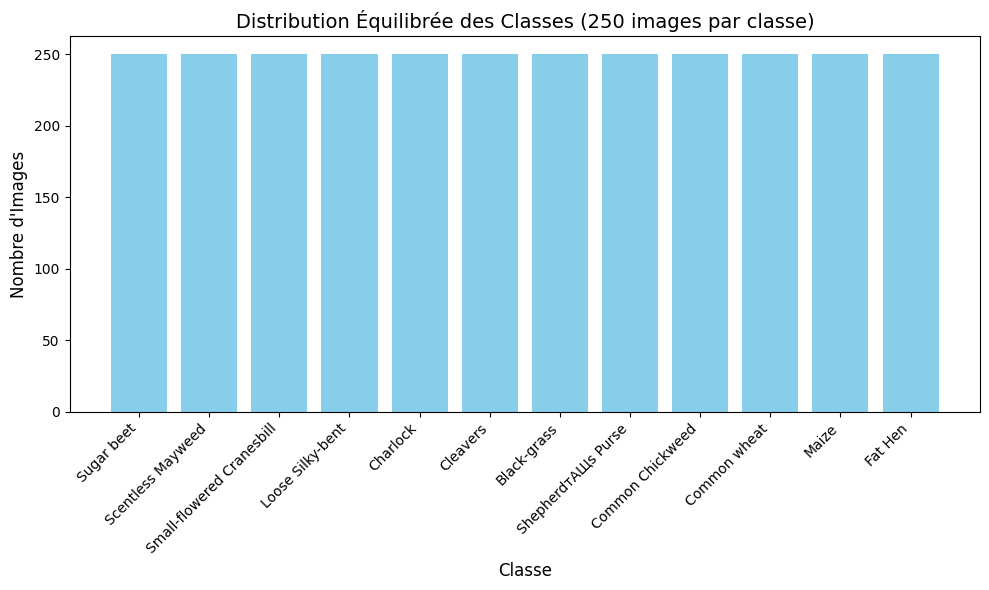

In [ ]:
# 3. Equilibrage de nombres d'images dans chaque classe (250)
def balance_classes(data_df, n_samples_per_class=250):
    """Équilibre les classes en sous-échantillonnant ou sur-échantillonnant."""
    balanced_df = pd.DataFrame()

    for class_name in data_df['class'].unique():
        class_df = data_df[data_df['class'] == class_name]
        n_available = len(class_df)

        if n_available >= n_samples_per_class:
            # Sous-échantillonnage aléatoire
            sampled_df = class_df.sample(n_samples_per_class, random_state=42)
            print(f"{class_name}: {n_available} → {n_samples_per_class} (sous-échantillonnage)")
        else:
            # Sur-échantillonnage avec remplacement
            sampled_df = class_df.sample(n_samples_per_class, replace=True, random_state=42)
            print(f"{class_name}: {n_available} → {n_samples_per_class} (sur-échantillonnage)")

        balanced_df = pd.concat([balanced_df, sampled_df])

    return balanced_df.reset_index(drop=True)

# Équilibrer les classes
balanced_df = balance_classes(data_clean_df, n_samples_per_class=250)

# Vérifier la distribution des classes après équilibrage
class_counts = balanced_df['class'].value_counts()
print("\nDistribution après équilibrage:")
print(class_counts)

# Visualiser la distribution équilibrée
plt.figure(figsize=(10, 6))
plt.bar(class_counts.index, class_counts.values, color='skyblue')
plt.title('Distribution Équilibrée des Classes (250 images par classe)', fontsize=14)
plt.xlabel('Classe', fontsize=12)
plt.ylabel('Nombre d\'Images', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [ ]:
# 4. Résolution fixe pour toutes les images (224x224)
def resize_image(img_path, output_path, target_size=(224, 224)):
    """Redimensionne une image à la taille cible."""
    img = cv2.imread(img_path)
    if img is None:
        print(f"Erreur: Impossible de lire l'image {img_path}")
        return False

    # Redimensionnement
    img_resized = cv2.resize(img, target_size)

    # Créer le répertoire de sortie si nécessaire
    os.makedirs(os.path.dirname(output_path), exist_ok=True)

    # Sauvegarder l'image redimensionnée
    result = cv2.imwrite(output_path, img_resized)
    return result

# Créer un répertoire pour les images redimensionnées
resized_dir = 'resized_images'
os.makedirs(resized_dir, exist_ok=True)

# Créer un sous-répertoire pour chaque classe
for class_name in balanced_df['class'].unique():
    os.makedirs(os.path.join(resized_dir, class_name), exist_ok=True)

# Redimensionner toutes les images
resized_paths = []
for i, row in balanced_df.iterrows():
    img_path = row['image_path']
    class_name = row['class']

    # Définir le chemin de sortie
    output_filename = f"{i:05d}_{os.path.basename(img_path)}"
    output_path = os.path.join(resized_dir, class_name, output_filename)

    # Redimensionner l'image
    if resize_image(img_path, output_path):
        resized_paths.append(output_path)

    # Afficher la progression
    if (i + 1) % 100 == 0:
        print(f"Redimensionnement: {i+1}/{len(balanced_df)} images traitées")

# Mettre à jour le DataFrame avec les nouveaux chemins
balanced_df['image_path'] = resized_paths
print(f"Redimensionnement terminé: {len(resized_paths)} images à 224×224")

Redimensionnement: 100/3000 images traitées
Redimensionnement: 200/3000 images traitées
Redimensionnement: 300/3000 images traitées
Redimensionnement: 400/3000 images traitées
Redimensionnement: 500/3000 images traitées
Redimensionnement: 600/3000 images traitées
Redimensionnement: 700/3000 images traitées
Redimensionnement: 800/3000 images traitées
Redimensionnement: 900/3000 images traitées
Redimensionnement: 1000/3000 images traitées
Redimensionnement: 1100/3000 images traitées
Redimensionnement: 1200/3000 images traitées
Redimensionnement: 1300/3000 images traitées
Redimensionnement: 1400/3000 images traitées
Redimensionnement: 1500/3000 images traitées
Redimensionnement: 1600/3000 images traitées
Redimensionnement: 1700/3000 images traitées
Redimensionnement: 1800/3000 images traitées
Redimensionnement: 1900/3000 images traitées
Redimensionnement: 2000/3000 images traitées
Redimensionnement: 2100/3000 images traitées
Redimensionnement: 2200/3000 images traitées
Redimensionnement: 

In [ ]:
# Application de PCA sur les images redimensionnées
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# 1. Fonction pour préparer une image pour PCA
def prepare_image_for_pca(img_path):
    """Charge une image et la convertit en vecteur pour PCA"""
    img = cv2.imread(img_path)
    if img is None:
        print(f"Erreur de lecture: {img_path}")
        return np.zeros(224*224*3)  # Vecteur nul en cas d'erreur

    # Convertir BGR à RGB
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Aplatir l'image en un vecteur
    img_flat = img.reshape(-1)  # 224*224*3 = 150,528 dimensions

    return img_flat

# 2. Prendre un échantillon pour ajuster le PCA (pour économiser de la mémoire)
print("Préparation d'un échantillon pour PCA...")
sample_size = min(1000, len(balanced_df))  # Limiter à 1000 images pour la mémoire
sample_df = balanced_df.sample(sample_size, random_state=42)

# 3. Charger et préparer les images échantillonnées
X_sample = []
for img_path in sample_df['image_path']:
    X_sample.append(prepare_image_for_pca(img_path))
X_sample = np.array(X_sample)

print(f"Forme des données échantillonnées: {X_sample.shape}")

# 4. Normaliser les données avant PCA
print("Normalisation des données...")
scaler = StandardScaler()
X_sample_scaled = scaler.fit_transform(X_sample)

# 5. Appliquer PCA pour conserver 95% de la variance
print("Application de PCA...")
pca = PCA(n_components=0.95, random_state=42)
pca.fit(X_sample_scaled)

# 6. Informations sur la réduction de dimensionnalité
n_components = pca.n_components_
explained_variance = pca.explained_variance_ratio_
total_variance = np.sum(explained_variance)

print(f"Nombre de composantes principales retenues: {n_components}")
print(f"Variance totale expliquée: {total_variance:.2%}")
print(f"Réduction de dimensionnalité: {X_sample.shape[1]} → {n_components} ({n_components/X_sample.shape[1]:.2%})")

# 7. Visualiser la variance expliquée
plt.figure(figsize=(10, 5))
plt.plot(np.cumsum(explained_variance), marker='o', linestyle='-')
plt.axhline(y=0.95, color='r', linestyle='--', label='Seuil à 95%')
plt.xlabel('Nombre de Composantes')
plt.ylabel('Variance Expliquée Cumulée')
plt.title('Variance Expliquée Cumulée par Composante Principale')
plt.grid(True)
plt.legend()
plt.show()

# 8. Visualiser les 10 premières composantes les plus importantes
plt.figure(figsize=(10, 5))
plt.bar(range(min(10, n_components)), explained_variance[:10], alpha=0.7)
plt.xlabel('Indice de la Composante')
plt.ylabel('Variance Expliquée')
plt.title('Variance Expliquée par les 10 Premières Composantes')
plt.grid(axis='y', alpha=0.3)
plt.show()

# 9. Appliquer PCA à tout le dataset
print("Application de PCA à toutes les images...")
X_pca_features = []
y_labels = []

for i, row in balanced_df.iterrows():
    img_path = row['image_path']
    img_class = row['class']

    # Préparer l'image
    img_flat = prepare_image_for_pca(img_path)

    # Normaliser
    img_scaled = scaler.transform(img_flat.reshape(1, -1))

    # Appliquer PCA
    img_pca = pca.transform(img_scaled).flatten()

    X_pca_features.append(img_pca)
    y_labels.append(img_class)

    # Afficher la progression
    if (i + 1) % 100 == 0:
        print(f"PCA appliquée à {i+1}/{len(balanced_df)} images")

# 10. Convertir en arrays numpy
X_pca_features = np.array(X_pca_features)
y_labels = np.array(y_labels)

print(f"Forme finale des caractéristiques PCA: {X_pca_features.shape}")

# 11. Créer un nouveau DataFrame avec les caractéristiques PCA
pca_df = balanced_df.copy()
pca_df['pca_features'] = list(X_pca_features)  # Ajouter les features PCA comme liste

# 12. Division en ensembles train/val/test pour les données PCA
# Créer un mappage des classes pour la modélisation
classes = sorted(pca_df['class'].unique())
class_to_idx = {cls: i for i, cls in enumerate(classes)}
pca_df['class_idx'] = pca_df['class'].map(class_to_idx)

# Première division : 80% train+val, 20% test
pca_train_val_df, pca_test_df = train_test_split(
    pca_df,
    test_size=0.2,
    stratify=pca_df['class'],
    random_state=42
)

# Deuxième division : diviser train_val en train (80%) et val (20%)
pca_train_df, pca_val_df = train_test_split(
    pca_train_val_df,
    test_size=0.2,
    stratify=pca_train_val_df['class'],
    random_state=42
)

print(f"PCA - Ensemble d'entraînement: {len(pca_train_df)} images")
print(f"PCA - Ensemble de validation: {len(pca_val_df)} images")
print(f"PCA - Ensemble de test: {len(pca_test_df)} images")

# 13. Sauvegarder les données PCA (facultatif)
import pickle

# Créer un dictionnaire avec toutes les informations nécessaires
pca_data = {
    'pca_model': pca,
    'scaler': scaler,
    'X_train': np.array(pca_train_df['pca_features'].tolist()),
    'y_train': pca_train_df['class_idx'].values,
    'X_val': np.array(pca_val_df['pca_features'].tolist()),
    'y_val': pca_val_df['class_idx'].values,
    'X_test': np.array(pca_test_df['pca_features'].tolist()),
    'y_test': pca_test_df['class_idx'].values,
    'class_mapping': class_to_idx
}

# Sauvegarder les données
with open('pca_features.pkl', 'wb') as f:
    pickle.dump(pca_data, f)

print("Données PCA sauvegardées dans 'pca_features.pkl'")

Préparation d'un échantillon pour PCA...


KeyboardInterrupt: 

Segmentation: 100/3000 images traitées
Segmentation: 200/3000 images traitées
Segmentation: 300/3000 images traitées
Segmentation: 400/3000 images traitées
Segmentation: 500/3000 images traitées
Segmentation: 600/3000 images traitées
Segmentation: 700/3000 images traitées
Segmentation: 800/3000 images traitées
Segmentation: 900/3000 images traitées
Segmentation: 1000/3000 images traitées
Segmentation: 1100/3000 images traitées
Segmentation: 1200/3000 images traitées
Segmentation: 1300/3000 images traitées
Segmentation: 1400/3000 images traitées
Segmentation: 1500/3000 images traitées
Segmentation: 1600/3000 images traitées
Segmentation: 1700/3000 images traitées
Segmentation: 1800/3000 images traitées
Segmentation: 1900/3000 images traitées
Segmentation: 2000/3000 images traitées
Segmentation: 2100/3000 images traitées
Segmentation: 2200/3000 images traitées
Segmentation: 2300/3000 images traitées
Segmentation: 2400/3000 images traitées
Segmentation: 2500/3000 images traitées
Segmentat

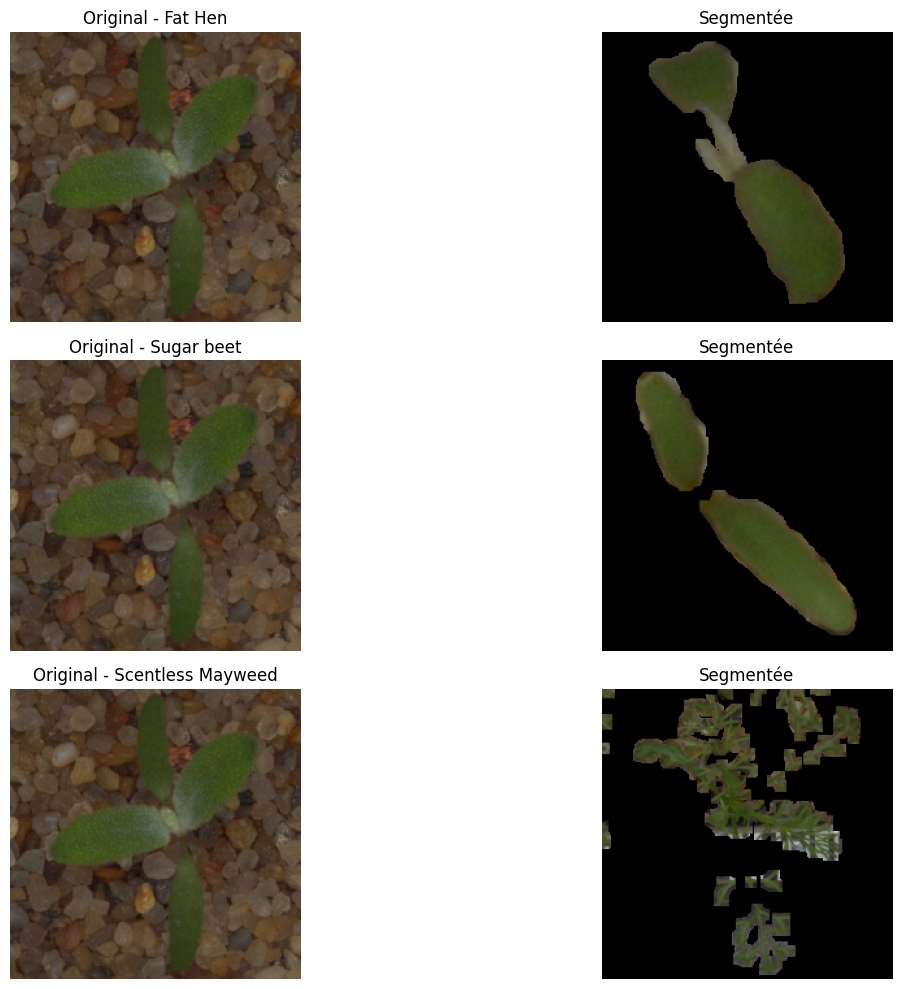

In [ ]:
# Fonction de segmentation pour isoler la plante (fond noir, plante en couleur)
def segment_plant(image_path, output_path=None):
    """
    Segmente une image pour isoler la plante (fond noir, plante en couleur d'origine)
    """
    # Charger l'image
    img = cv2.imread(image_path)
    if img is None:
        print(f"Erreur: Impossible de lire l'image {image_path}")
        return None

    # Convertir l'image de BGR à RGB
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Convertir en HSV pour une meilleure détection des couleurs
    hsv = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2HSV)

    # Définir la plage de couleurs vertes dans HSV
    # Ajustez ces valeurs selon les caractéristiques de vos images
    lower_green = np.array([25, 40, 40])
    upper_green = np.array([90, 255, 255])

    # Créer un masque pour la couleur verte
    mask = cv2.inRange(hsv, lower_green, upper_green)

    # Améliorer le masque avec des opérations morphologiques
    kernel = np.ones((5, 5), np.uint8)
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)

    # Dilater légèrement pour inclure les bords
    mask = cv2.dilate(mask, kernel, iterations=1)

    # Créer une image noire de même taille
    black_bg = np.zeros_like(img_rgb)

    # Copier uniquement les pixels de la plante
    segmented = black_bg.copy()
    segmented[mask > 0] = img_rgb[mask > 0]

    # Si un chemin de sortie est spécifié, sauvegarder l'image
    if output_path:
        os.makedirs(os.path.dirname(output_path), exist_ok=True)
        cv2.imwrite(output_path, cv2.cvtColor(segmented, cv2.COLOR_RGB2BGR))

    return segmented

# Créer un dossier pour les images segmentées
segmented_dir = 'segmented_images'
os.makedirs(segmented_dir, exist_ok=True)

# Créer un sous-répertoire pour chaque classe
for class_name in balanced_df['class'].unique():
    os.makedirs(os.path.join(segmented_dir, class_name), exist_ok=True)

# Segmenter toutes les images
segmented_paths = []
for i, row in balanced_df.iterrows():
    img_path = row['image_path']
    class_name = row['class']

    # Définir le chemin de sortie
    output_filename = f"{i:05d}_{os.path.basename(img_path)}"
    output_path = os.path.join(segmented_dir, class_name, output_filename)

    # Segmenter l'image
    segment_plant(img_path, output_path)
    segmented_paths.append(output_path)

    # Afficher la progression
    if (i + 1) % 100 == 0:
        print(f"Segmentation: {i+1}/{len(balanced_df)} images traitées")

# Mettre à jour le DataFrame avec les nouveaux chemins
balanced_df['image_path'] = segmented_paths
print(f"Segmentation terminée: {len(segmented_paths)} images segmentées")

# Afficher quelques exemples de segmentation
sample_indices = np.random.choice(len(balanced_df), size=3, replace=False)
plt.figure(figsize=(15, 10))

for i, idx in enumerate(sample_indices):
    # Image originale (avant segmentation)
    original_path = row['image_path'].replace(segmented_dir, 'resized_images')
    if os.path.exists(original_path):
        original = cv2.imread(original_path)
        original = cv2.cvtColor(original, cv2.COLOR_BGR2RGB)
    else:
        original = np.zeros((224, 224, 3), dtype=np.uint8)  # Image noire si l'originale n'est pas trouvée

    # Image segmentée
    segmented_path = balanced_df.iloc[idx]['image_path']
    segmented = cv2.imread(segmented_path)
    segmented = cv2.cvtColor(segmented, cv2.COLOR_BGR2RGB)

    # Afficher les images côte à côte
    plt.subplot(3, 2, i*2 + 1)
    plt.imshow(original)
    plt.title(f"Original - {balanced_df.iloc[idx]['class']}")
    plt.axis('off')

    plt.subplot(3, 2, i*2 + 2)
    plt.imshow(segmented)
    plt.title("Segmentée")
    plt.axis('off')

plt.tight_layout()
plt.show()

Ensemble d'entraînement: 3544 images (64.0%)
Ensemble de validation: 887 images (16.0%)
Ensemble de test: 1108 images (20.0%)


Train  Validation  Test
class                                             
Black-grass                  197          50    62
Charlock                     289          73    90
Cleavers                     214          54    67
Common Chickweed             456         114   143
Common wheat                 162          40    51
Fat Hen                      344          86   108
Loose Silky-bent             488         122   152
Maize                        165          41    51
Scentless Mayweed            389          97   121
ShepherdтАЩs Purse           175          44    55
Small-flowered Cranesbill    369          92   115
Sugar beet                   296          74    93

<Figure size 1200x600 with 0 Axes>

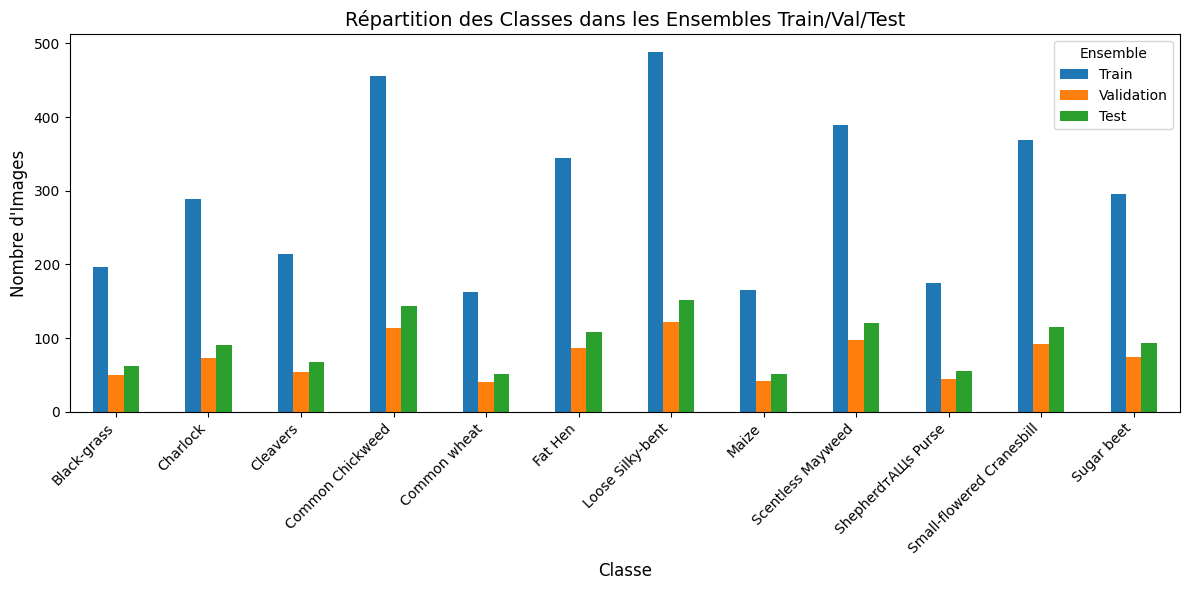

In [ ]:
# Division en ensembles train/val/test
from sklearn.model_selection import train_test_split

# 1. Première division : 80% train+val, 20% test
train_val_df, test_df = train_test_split(
    data_df,
    test_size=0.2,  # 20% pour le test
    stratify=data_df['class'],  # Maintenir la distribution des classes
    random_state=42
)

# 2. Deuxième division : diviser train_val en train (80%) et val (20%)
# 20% de 80% = 16% du total, donc val = 16% du dataset total
train_df, val_df = train_test_split(
    train_val_df,
    test_size=0.2,  # 20% du train_val (soit 0.2 * 0.8 = 0.16 ou 16% du total)
    stratify=train_val_df['class'],  # Maintenir la distribution des classes
    random_state=42
)

# Afficher les tailles des ensembles
print(f"Ensemble d'entraînement: {len(train_df)} images ({len(train_df)/len(data_df)*100:.1f}%)")
print(f"Ensemble de validation: {len(val_df)} images ({len(val_df)/len(data_df)*100:.1f}%)")
print(f"Ensemble de test: {len(test_df)} images ({len(test_df)/len(data_df)*100:.1f}%)")

# Vérifier la distribution des classes dans chaque ensemble
train_dist = train_df['class'].value_counts().sort_index()
val_dist = val_df['class'].value_counts().sort_index()
test_dist = test_df['class'].value_counts().sort_index()

# Créer un DataFrame pour la comparaison
comparison_df = pd.DataFrame({
    'Train': train_dist,
    'Validation': val_dist,
    'Test': test_dist
})

display(comparison_df)

# Visualiser la répartition des classes dans chaque ensemble
plt.figure(figsize=(12, 6))
comparison_df.plot(kind='bar', figsize=(12, 6))
plt.title('Répartition des Classes dans les Ensembles Train/Val/Test', fontsize=14)
plt.xlabel('Classe', fontsize=12)
plt.ylabel('Nombre d\'Images', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.legend(title='Ensemble')
plt.tight_layout()
plt.show()

*Cette méthode garantit que:*
1. Le jeu de données de test représente exactement 20% du total
2. Le jeu de données de validation représente 20% des 80% restants (soit environ 16% du total)
3. Le jeu de données d'entraînement représente le reste (environ 64%)
4. La distribution des classes est préservée dans chaque ensemble grâce au paramètre stratify


*Output*
* train_df
* val_df
* test_df

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import efficientnet

train_generator_eff_net = ImageDataGenerator(
    preprocessing_function = efficientnet.preprocess_input,
    validation_split = 0.2
)

test_generator_eff_net = ImageDataGenerator(
    preprocessing_function = efficientnet.preprocess_input
)

In [ ]:
from sklearn.model_selection import train_test_split

train_df1, test_df1 = train_test_split(
    balanced_df,
    train_size=0.8,
    shuffle=True,
    random_state=42,
    stratify=balanced_df[["class"]]
)

train = train_generator_eff_net.flow_from_dataframe(
    dataframe=train_df1,
    x_col="image_path",
    y_col="class",
    target_size=(224, 224),
    color_mode="rgb",
    class_mode="categorical",
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='training',
    rotation_range=32,
    zoom_range=0.2,
    width_shift_range=0.2,
    height_shift_range=0.2,
    sheer_range=0.2,
    brightness_range=[0.5,1.5],
    horizontal_flip=True,
    fill_mode="nearest"
)

validation = train_generator_eff_net.flow_from_dataframe(
    dataframe=train_df1,
    x_col="image_path",
    y_col="class",
    target_size=(224, 224),
    color_mode="rgb",
    class_mode="categorical",
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='validation',
    rotation_range=32,
    zoom_range=0.2,
    width_shift_range=0.2,
    height_shift_range=0.2,
    brightness_range=[0.5,1.5],
    sheer_range=0.2,
    horizontal_flip=True,
    fill_mode="nearest"
)

test = test_generator_eff_net.flow_from_dataframe(
    dataframe=test_df1,
    x_col="image_path",
    y_col="class",
    target_size=(224, 224),
    color_mode="rgb",
    class_mode="categorical",
    batch_size=32,
    rotation_range=32,
    zoom_range=0.2,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shuffle=False
)

Found 1920 validated image filenames belonging to 12 classes.
Found 480 validated image filenames belonging to 12 classes.
Found 600 validated image filenames belonging to 12 classes.


In [ ]:
import os
import shutil
import pandas as pd

# Dossier de destination
destination_dir = "/content/drive/MyDrive/test"
os.makedirs(destination_dir, exist_ok=True)

copied_files = []

for idx, row in test_df1.iterrows():
    img_path = row["image_path"]
    class_label = row["class"]
    file_name = os.path.basename(img_path)

    # Vérifier que le fichier existe
    if not os.path.exists(img_path):
        print(f"❌ Fichier introuvable : {img_path}")
        continue

    # Dossier de classe
    class_dir = os.path.join(destination_dir, class_label)
    os.makedirs(class_dir, exist_ok=True)

    destination_path = os.path.join(class_dir, file_name)

    # Affichage de debug
    print(f"Copie de: {img_path} --> {destination_path}")

    try:
        shutil.copy(img_path, destination_path)
        copied_files.append({
            "file_name": file_name,
            "class": class_label,
            "original_path": img_path,
            "new_path": destination_path
        })
    except Exception as e:
        print(f"❌ Erreur lors de la copie de {img_path}: {e}")

# Sauvegarde du CSV
csv_path = os.path.join(destination_dir, "images_test_labels.csv")
df_copied = pd.DataFrame(copied_files)
df_copied.to_csv(csv_path, index=False)

print(f"\n✅ Terminé : {len(copied_files)} images copiées dans {destination_dir}")

Copie de: resized_images/Cleavers/01469_312.png --> /content/drive/MyDrive/test/Cleavers/01469_312.png
Copie de: resized_images/Scentless Mayweed/00325_400.png --> /content/drive/MyDrive/test/Scentless Mayweed/00325_400.png
Copie de: resized_images/Black-grass/01710_117.png --> /content/drive/MyDrive/test/Black-grass/01710_117.png
Copie de: resized_images/ShepherdтАЩs Purse/01919_165.png --> /content/drive/MyDrive/test/ShepherdтАЩs Purse/01919_165.png
Copie de: resized_images/ShepherdтАЩs Purse/01895_20.png --> /content/drive/MyDrive/test/ShepherdтАЩs Purse/01895_20.png
Copie de: resized_images/Cleavers/01265_105.png --> /content/drive/MyDrive/test/Cleavers/01265_105.png
Copie de: resized_images/Sugar beet/00157_416.png --> /content/drive/MyDrive/test/Sugar beet/00157_416.png
Copie de: resized_images/Common Chickweed/02109_436.png --> /content/drive/MyDrive/test/Common Chickweed/02109_436.png
Copie de: resized_images/Common wheat/02400_126.png --> /content/drive/MyDrive/test/Common whe

# **Modélisation**

## **Modéle MobileNetV2**

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam

In [ ]:
# Load the pre-trained model MobileNetV2
pretrained_model = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)

pretrained_model.trainable = False

inputs = pretrained_model.input
x = tf.keras.layers.Dense(128, activation='relu')(pretrained_model.output)
x = tf.keras.layers.Dense(128, activation='relu')(x)
outputs = tf.keras.layers.Dense(12, activation='softmax')(x)


model4 = tf.keras.Model(inputs=inputs, outputs=outputs)

model4.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

def dataframe_to_generator(dataframe, batch_size=32):
    datagen = ImageDataGenerator(rescale=1./255)

    generator = datagen.flow_from_dataframe(
        dataframe,
        x_col='image_path',  # column with file paths
        y_col='class',       # column with class labels
        target_size=(224, 224),
        batch_size=batch_size,
        class_mode='categorical'
    )
    return generator

# Create generators
train_gen = dataframe_to_generator(train_df)
val_gen = dataframe_to_generator(val_df)

# Define proper callbacks
callbacks = [
    EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
    ModelCheckpoint('best_model.h5', save_best_only=True)
]

# Train the model
history = model4.fit(
    train_gen,
    validation_data=val_gen,
    epochs=10,
    callbacks=callbacks  # Use the actual callbacks list here
)

Found 3544 validated image filenames belonging to 12 classes.
Found 887 validated image filenames belonging to 12 classes.
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - accuracy: 0.4579 - loss: 1.6863

111/111 ━━━━━━━━━━━━━━━━━━━━ 35s 214ms/step - accuracy: 0.4592 - loss: 1.6822 - val_accuracy: 0.7238 - val_loss: 0.7871
Epoch 2/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - accuracy: 0.7889 - loss: 0.6054

111/111 ━━━━━━━━━━━━━━━━━━━━ 13s 113ms/step - accuracy: 0.7889 - loss: 0.6053 - val_accuracy: 0.7903 - val_loss: 0.6092
Epoch 3/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - accuracy: 0.8545 - loss: 0.4152

111/111 ━━━━━━━━━━━━━━━━━━━━ 21s 116ms/step - accuracy: 0.8545 - loss: 0.4153 - val_accuracy: 0.8083 - val_loss: 0.5261
Epoch 4/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - accuracy: 0.8812 - loss: 0.3588

111/111 ━━━━━━━━━━━━━━━━━━━━ 13s 113ms/step - accuracy: 0.8811 - loss: 0.3587 - val_accuracy: 0.8117 - val_loss: 0.5040
Epoch 5/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 12s 111ms/step - accuracy: 0.9080 - loss: 0.2663 - val_accuracy: 0.7914 - val_loss: 0.5816
Epoch 6/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 12s 109ms/step - accuracy: 0.9316 - loss: 0.2155 - val_accuracy: 0.8162 - val_loss: 0.5379
Epoch 7/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 12s 108ms/step - accuracy: 0.9458 - loss: 0.1853 - val_accuracy: 0.8027 - val_loss: 0.5895


## **Evaluation**

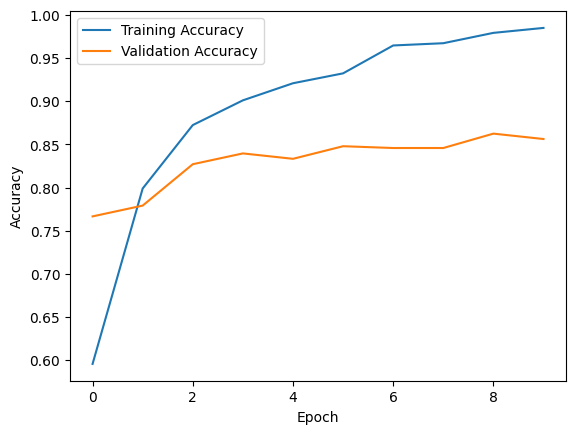

In [ ]:
# Plot the training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

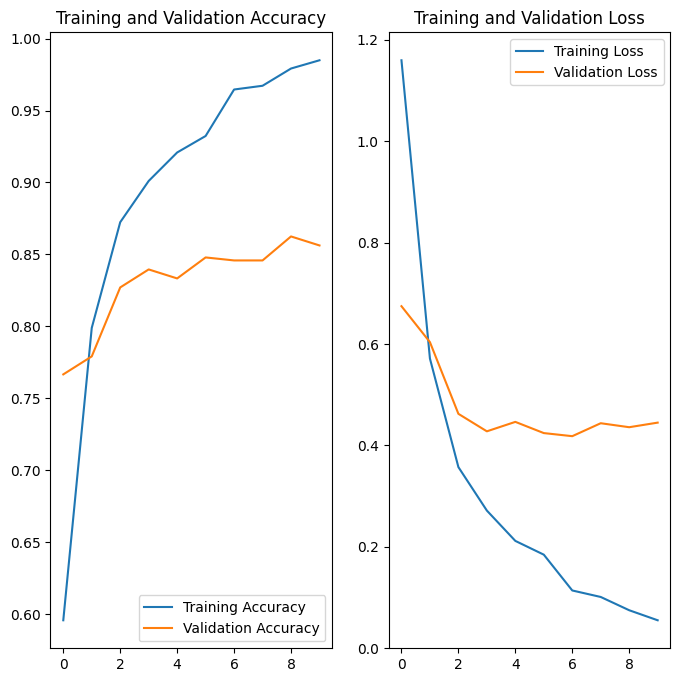

In [ ]:
import matplotlib.pyplot as plt

# Assuming you have the history object from model training
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

# Change the epochs_range variable to be the actual number of epochs that were run
epochs_range = range(len(history.history['loss']))

plt.figure(figsize=(8, 8))

# Plotting Accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

# Plotting Loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

# Display the plot
plt.show()

Found 1108 validated image filenames belonging to 12 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


35/35 ━━━━━━━━━━━━━━━━━━━━ 11s 236ms/step


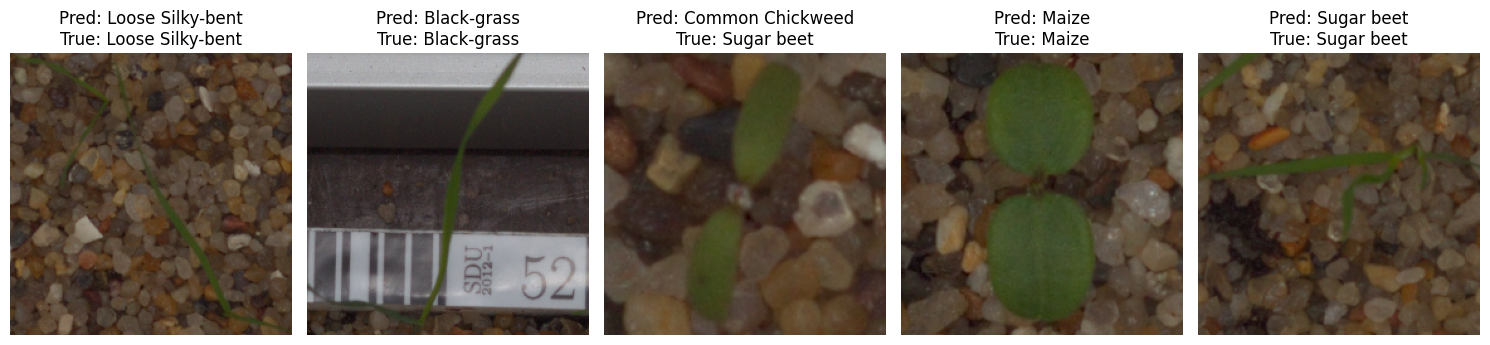


Classification Report:
                           precision    recall  f1-score   support

              Black-grass       0.52      0.55      0.54        62
                 Charlock       0.92      0.87      0.89        90
                 Cleavers       0.90      0.81      0.85        67
         Common Chickweed       0.71      0.93      0.80       143
             Common wheat       0.86      0.75      0.80        51
                  Fat Hen       0.72      0.77      0.74       108
         Loose Silky-bent       0.78      0.76      0.77       152
                    Maize       0.84      0.84      0.84        51
        Scentless Mayweed       0.76      0.81      0.78       121
       ShepherdтАЩs Purse       0.81      0.45      0.58        55
Small-flowered Cranesbill       0.96      0.89      0.92       115
               Sugar beet       0.88      0.82      0.85        93

                 accuracy                           0.79      1108
                macro avg       0.81

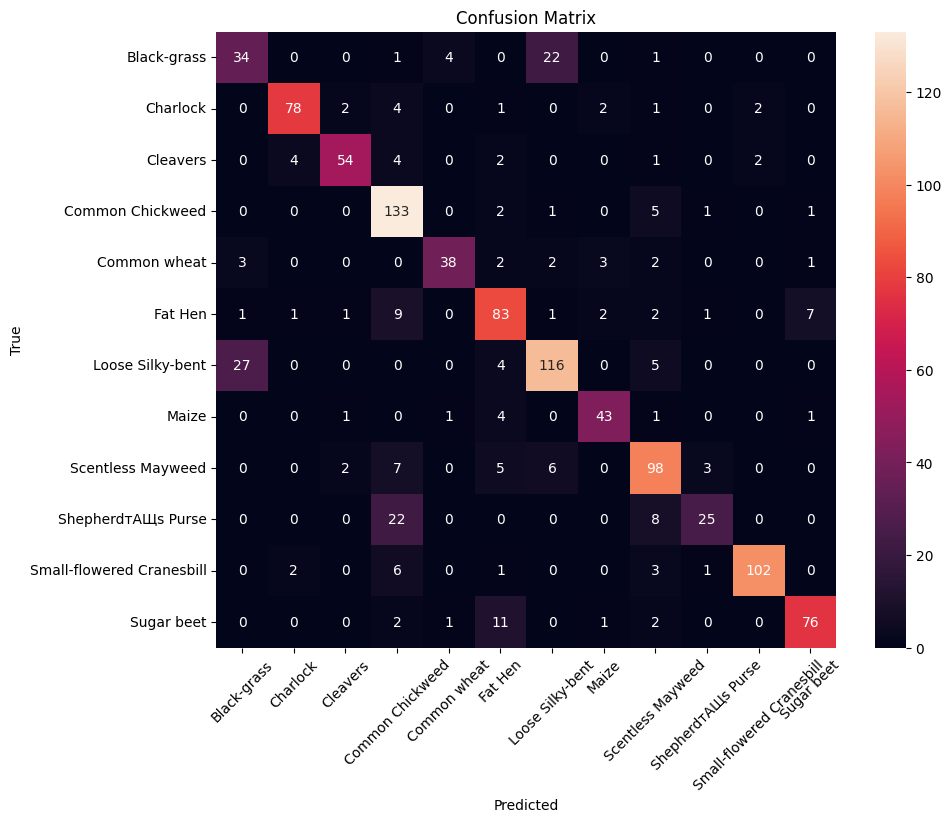

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# 1. Create test generator (with shuffle=False)
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_dataframe(
    test_df,
    x_col='image_path',
    y_col='class',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False  # Important for correct evaluation
)

# 2. Reset generator and get predictions
test_generator.reset()
predictions = model4.predict(test_generator)
predicted_labels = np.argmax(predictions, axis=1)
true_labels = test_generator.classes
class_names = list(test_generator.class_indices.keys())

# 3. Display sample predictions (CORRECTED)
plt.figure(figsize=(15, 5))
for i in range(5):  # Show first 5 images
    # Get image by index (alternative method)
    img = test_generator[i][0][0]  # First image of ith batch

    plt.subplot(1, 5, i+1)
    plt.imshow(img)
    plt.title(f"Pred: {class_names[predicted_labels[i]]}\nTrue: {class_names[true_labels[i]]}")
    plt.axis('off')
plt.tight_layout()
plt.show()

# 4. Evaluation metrics
print("\nClassification Report:")
print(classification_report(true_labels, predicted_labels, target_names=class_names))

# Confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.show()

## **Modéle efficientnet**

In [ ]:
from tensorflow.keras.applications import efficientnet

basemodel = efficientnet.EfficientNetB0(
                                          include_top=False,
                                          weights='imagenet',
                                          input_shape=(224,224,3),
                                          pooling='avg',
                                        )
# basemodel.summary()
basemodel.trainable = False

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [ ]:
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import CategoricalAccuracy

# building the Predictor layers
x = Dense(256, activation='relu')(basemodel.output)
x = Dense(128, activation='relu')(x)
x = Dropout(0.4)(x)

outputs = Dense(12, activation='softmax')(x)

efficientnet = Model(inputs=basemodel.inputs, outputs=outputs)

In [ ]:
efficientnet.compile(
    optimizer=Adam(),
    loss=CategoricalCrossentropy(),
    metrics=[CategoricalAccuracy()]
)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

# training
results = efficientnet.fit(
    train,
    validation_data = validation,
    batch_size = 32,
    epochs = 40,
    callbacks = [

        EarlyStopping(
            monitor="val_loss",
            patience=5,
            restore_best_weights=True
        ),
        ReduceLROnPlateau(patience=2)
    ]
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/40


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(None, 224, 224, 3))
  warnings.warn(msg)


60/60 ━━━━━━━━━━━━━━━━━━━━ 47s 235ms/step - categorical_accuracy: 0.3023 - loss: 2.0206 - val_categorical_accuracy: 0.6667 - val_loss: 1.0168 - learning_rate: 0.0010
Epoch 2/40
60/60 ━━━━━━━━━━━━━━━━━━━━ 7s 119ms/step - categorical_accuracy: 0.6444 - loss: 1.0427 - val_categorical_accuracy: 0.7646 - val_loss: 0.6666 - learning_rate: 0.0010
Epoch 3/40
60/60 ━━━━━━━━━━━━━━━━━━━━ 10s 112ms/step - categorical_accuracy: 0.7247 - loss: 0.7443 - val_categorical_accuracy: 0.8167 - val_loss: 0.5262 - learning_rate: 0.0010
Epoch 4/40
60/60 ━━━━━━━━━━━━━━━━━━━━ 12s 193ms/step - categorical_accuracy: 0.8123 - loss: 0.5331 - val_categorical_accuracy: 0.8375 - val_loss: 0.4512 - learning_rate: 0.0010
Epoch 5/40
60/60 ━━━━━━━━━━━━━━━━━━━━ 10s 168ms/step - categorical_accuracy: 0.8515 - loss: 0.4369 - val_categorical_accuracy: 0.8188 - val_loss: 0.4526 - learning_rate: 0.0010
Epoch 6/40
60/60 ━━━━━━━━━━━━━━━━━━━━ 7s 110ms/step - categorical_accuracy: 0.8488 - loss: 0.4145 - val_categorical_accuracy: 0

In [ ]:
model_save_path = "plant_classification_modelv2.h5"
efficientnet.save(model_save_path)
print(f"\nModel saved successfully at {model_save_path}")


Model saved successfully at plant_classification_modelv2.h5


## **Evaluation**

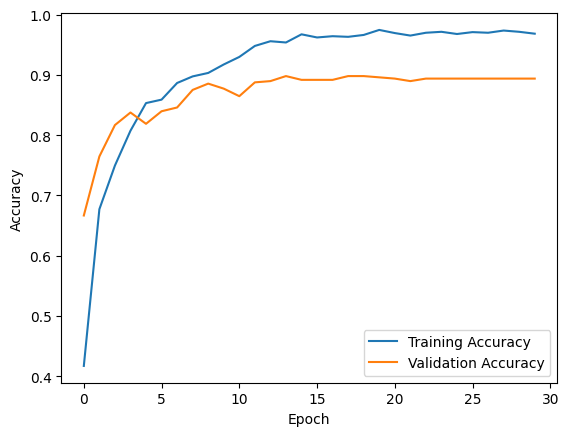

In [ ]:
# Plot the training and validation accuracy
plt.plot(results.history['categorical_accuracy'], label='Training Accuracy')
plt.plot(results.history['val_categorical_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

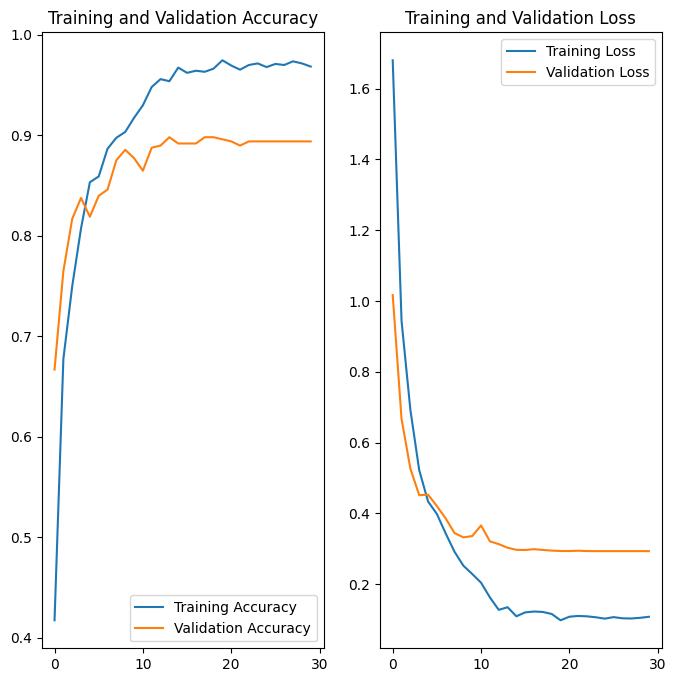

In [ ]:
import matplotlib.pyplot as plt

# Assuming you have the history object from model training
acc = results.history['categorical_accuracy']
val_acc = results.history['val_categorical_accuracy']

loss = results.history['loss']
val_loss = results.history['val_loss']

# Change the epochs_range variable to be the actual number of epochs that were run
epochs_range = range(len(results.history['loss']))

plt.figure(figsize=(8, 8))

# Plotting Accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

# Plotting Loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

# Display the plot
plt.show()

In [ ]:
# Charger le modèle si nécessaire
# from tensorflow.keras.models import load_model
# efficientnet = load_model('plant_classification_modelv4.h5')

# Évaluation
test_results = efficientnet.evaluate(test, verbose=1)
print(f"\nPerformance sur le test set:")
print(f"- Loss: {test_results[0]:.4f}")
print(f"- Accuracy: {test_results[1]:.4f}")

19/19 ━━━━━━━━━━━━━━━━━━━━ 9s 476ms/step - categorical_accuracy: 0.9150 - loss: 0.2907

Performance sur le test set:
- Loss: 0.3303
- Accuracy: 0.9033


In [ ]:
from sklearn.metrics import classification_report
import numpy as np

# Prédictions
test.reset()
y_pred = efficientnet.predict(test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Vraies labels
y_true = test.classes
class_names = list(test.class_indices.keys())

# Rapport
print("\nRapport de classification:")
print(classification_report(y_true, y_pred_classes, target_names=class_names))

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(32, 224, 224, 3))
  warnings.warn(msg)


19/19 ━━━━━━━━━━━━━━━━━━━━ 16s 450ms/step

Rapport de classification:
                           precision    recall  f1-score   support

              Black-grass       0.78      0.78      0.78        50
                 Charlock       1.00      1.00      1.00        50
                 Cleavers       0.98      0.94      0.96        50
         Common Chickweed       0.96      0.88      0.92        50
             Common wheat       0.87      0.96      0.91        50
                  Fat Hen       0.94      0.90      0.92        50
         Loose Silky-bent       0.88      0.76      0.82        50
                    Maize       0.98      0.94      0.96        50
        Scentless Mayweed       0.80      0.96      0.87        50
       ShepherdтАЩs Purse       0.86      0.88      0.87        50
Small-flowered Cranesbill       0.98      0.94      0.96        50
               Sugar beet       0.85      0.90      0.87        50

                 accuracy                           0.90 

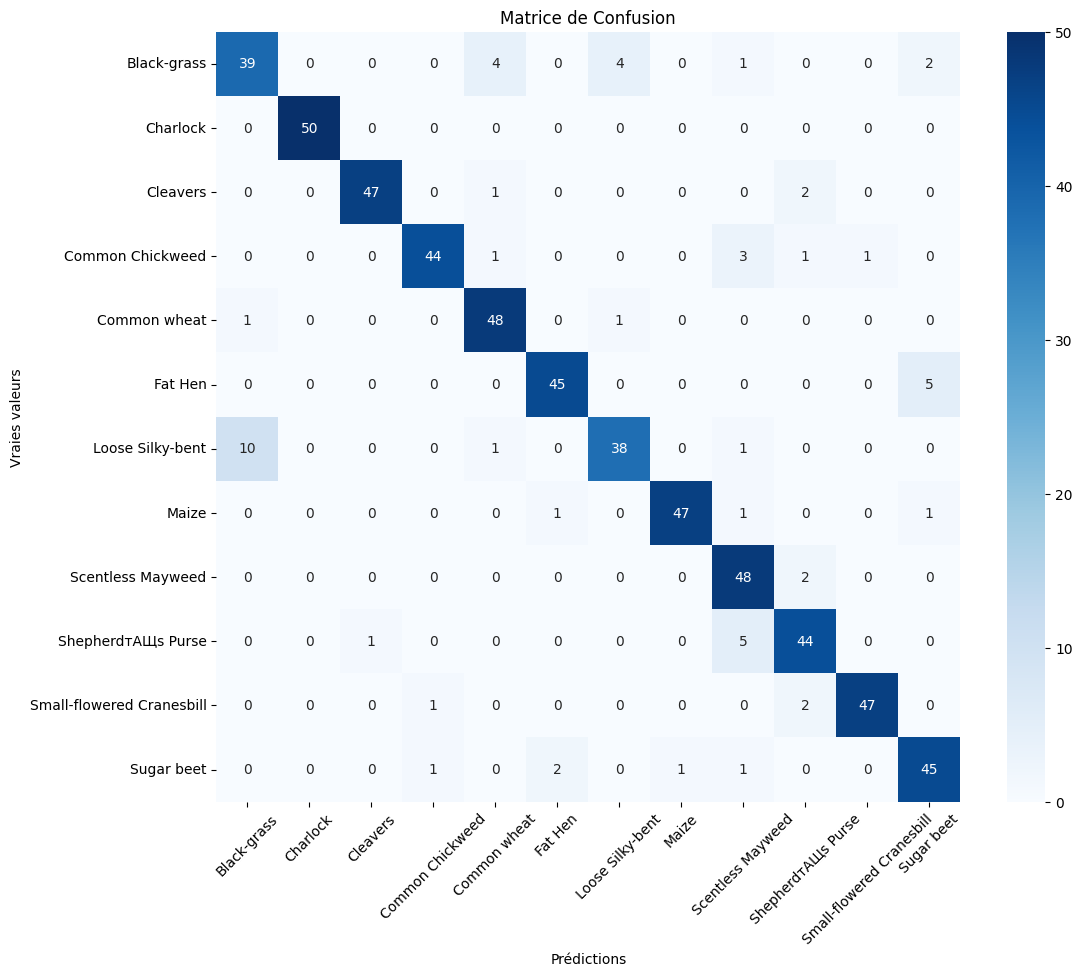

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_true, y_pred_classes)

plt.figure(figsize=(12,10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)
plt.title('Matrice de Confusion')
plt.xlabel('Prédictions')
plt.ylabel('Vraies valeurs')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.show()

19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 84ms/step


<ipython-input-24-235a85b67fd2>:22: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(img_path)


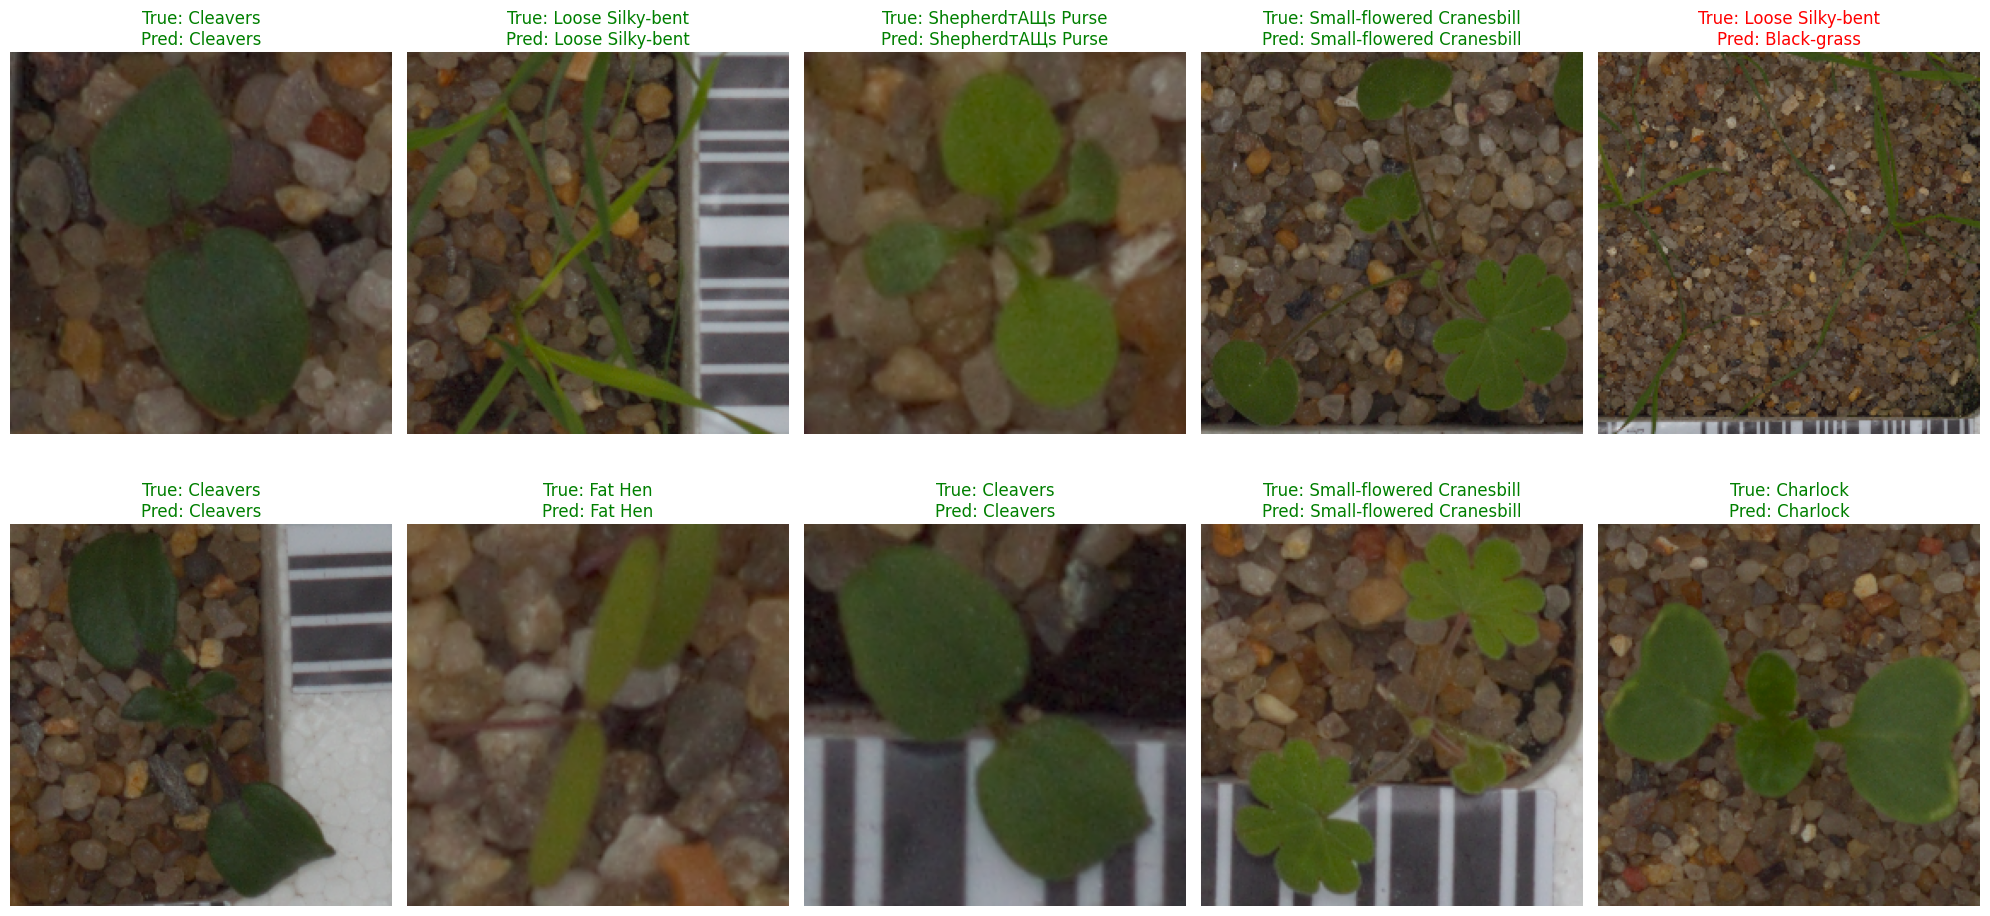

In [ ]:
import matplotlib.pyplot as plt
import imageio
import random

# Reverse class_indices dictionary
class_indices = train.class_indices
labels = dict((v, k) for k, v in class_indices.items())

# Predict using the model
predictions_raw = efficientnet.predict(test)
predicted_indices = np.argmax(predictions_raw, axis=1)
true_indices = test.classes
filepaths = test.filepaths

# Number of samples to visualize
num_samples = 10
indices = random.sample(range(len(filepaths)), num_samples)

plt.figure(figsize=(20, 10))
for i, idx in enumerate(indices):
    img_path = filepaths[idx]
    image = imageio.imread(img_path)
    true_label = labels[true_indices[idx]]
    predicted_label = labels[predicted_indices[idx]]
    color = "green" if true_label == predicted_label else "red"

    plt.subplot(2, 5, i + 1)
    plt.imshow(image)
    plt.title(f"True: {true_label}\nPred: {predicted_label}", color=color)
    plt.axis("off")

plt.tight_layout()
plt.show()